# Quality Score Models

In [174]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
from pathlib import Path

p = Path()

os.chdir(p.absolute())  # Change working directory to the notebook's directory


def plot(x, y, title="Data Plot", xlabel="X-axis", ylabel="Y-axis", save_path=None):
    """
    Plot a curve and fill the area under it.

    Args:
        data: array-like, the y-values to plot
        title: str, plot title
        xlabel: str, x-axis label
        ylabel: str, y-axis label
        save_path: str or None, if provided, saves the plot to this path
    """
    plt.plot(x, y)
    plt.fill_between(x, y, color="skyblue", alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(min(x), max(x))  # Limit x-axis to data range
    plt.ylim(bottom=0)  # Limit y-min to 0 for better visualization
    plt.gcf().set_size_inches(6, 2)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()

## Very Naive

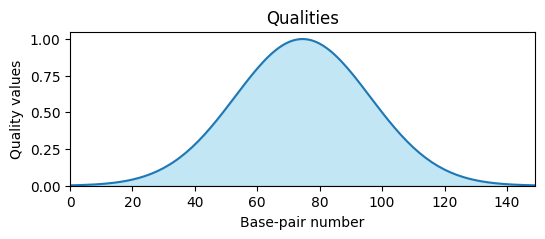

In [176]:
# A custom function to calculate
# probability distribution function
def pdf(x, max_value=1.0, steepness=2.0):
    mean = np.mean(x)
    std = np.std(x) / steepness
    y = 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-((x - mean) ** 2) / (2 * std**2))
    max_y = np.max(y)
    y_out = (y / max_y) * max_value
    return y_out


# To generate an array of x-values
x = np.arange(150)

# To generate an array of
# y-values using corresponding x-values
qualities = pdf(x)

# Plot
plot(x, qualities, title="Qualities", xlabel="Base-pair number", ylabel="Quality values")

In [177]:
def create_dips(positions, depth, width):
    """
    Create a dip in the quality scores at specified positions.

    Args:
        positions: list of int, positions to create dips
        depth: float, depth of the dip
        width: int, width of the dip
    Returns:
        dip: array-like, quality scores with dips
    """
    profile = pdf(np.arange(-width // 2, width // 2))
    max_value = np.max(profile)
    kernal = profile / max_value * -depth

    dip = np.ones(150)
    for pos in positions:
        start = max(0, pos - width // 2)
        end = min(150, pos + width // 2)
        dip[start:end] += kernal[: end - start]

    plot(np.arange(150), dip, title="Dips", xlabel="Base-pair number", ylabel="Quality values")

    return dip

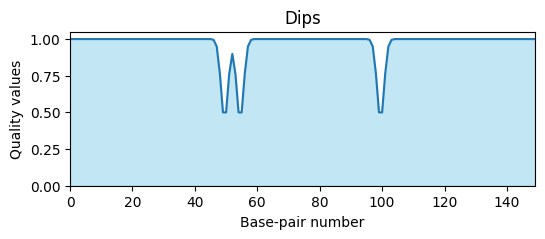

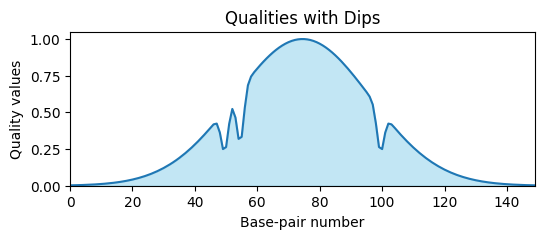

In [178]:
dips = create_dips(positions=[50, 55, 100], depth=0.5, width=8)

qualities_with_dips = qualities * dips
plot(
    x,
    qualities_with_dips,
    title="Qualities with Dips",
    xlabel="Base-pair number",
    ylabel="Quality values",
)

## NaiveQualModel with WelfordsRunningMean

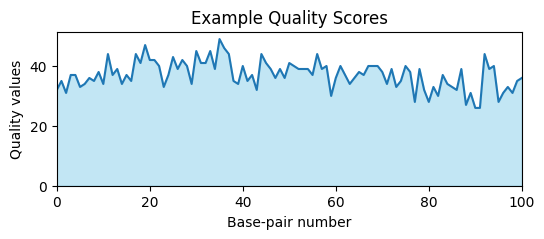

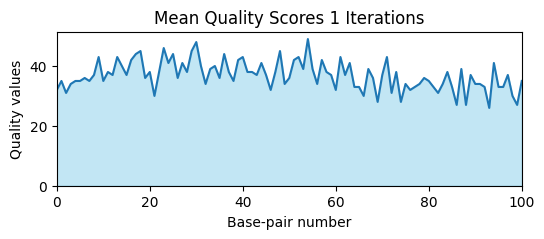

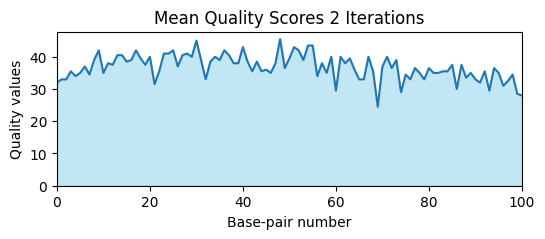

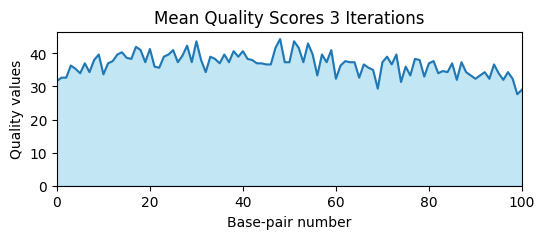

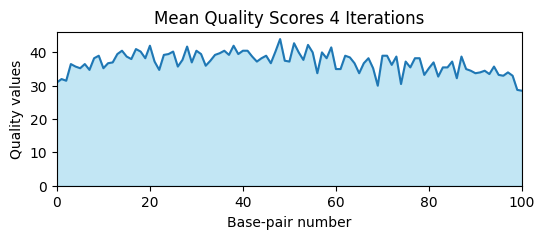

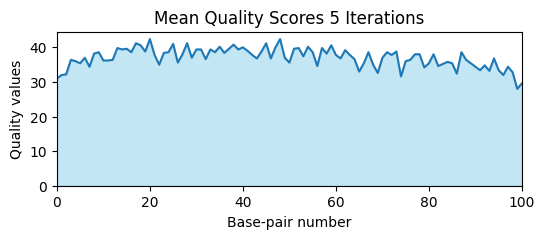

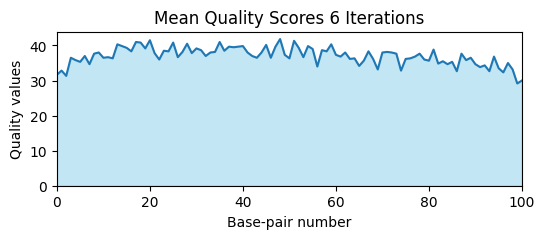

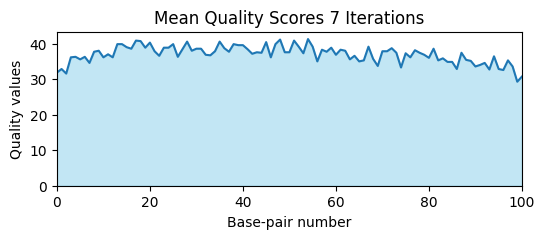

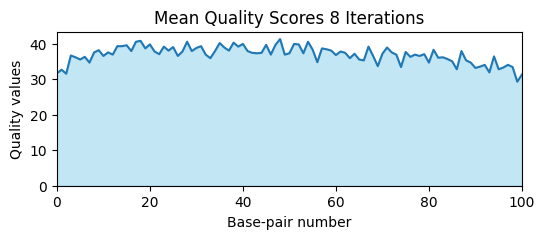

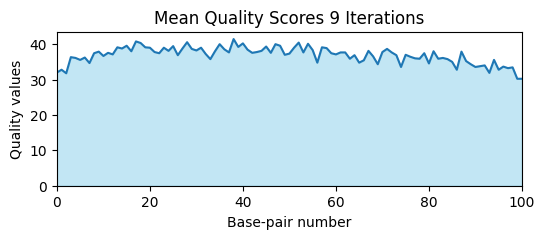

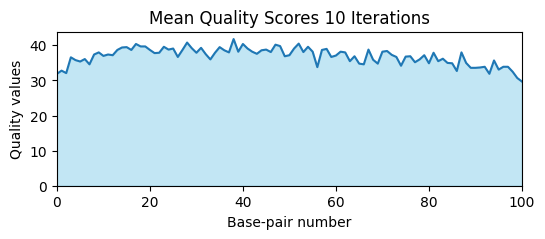

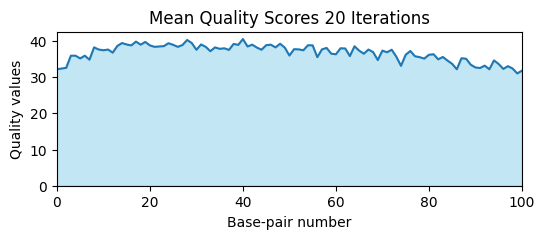

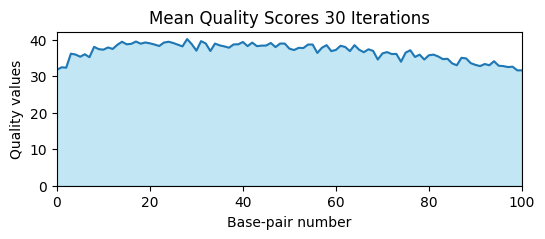

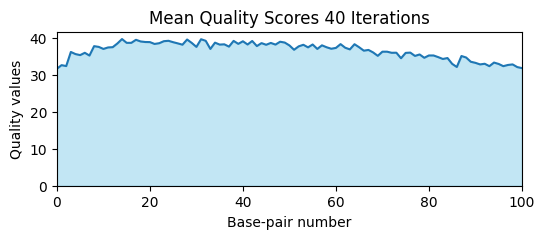

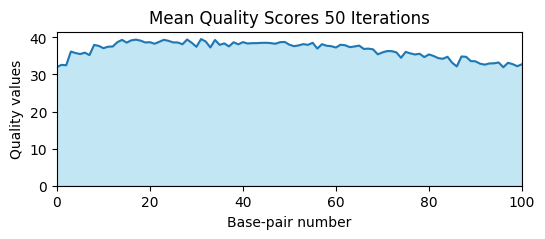

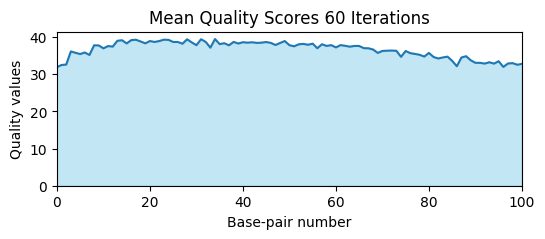

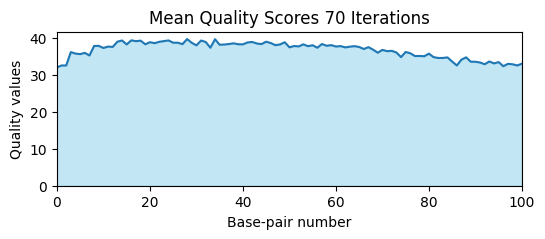

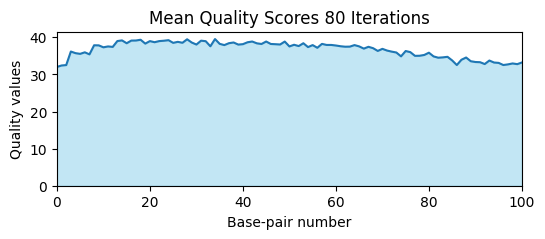

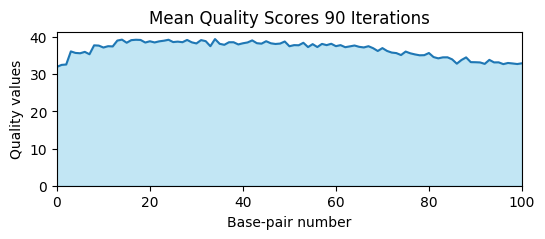

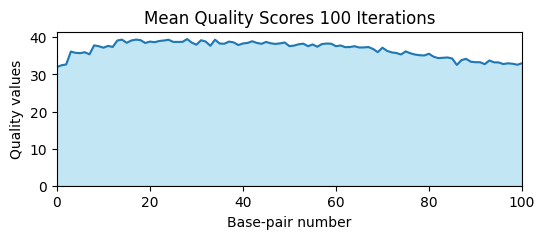

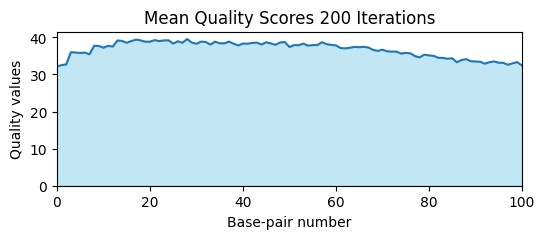

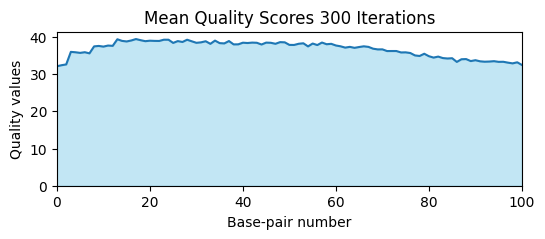

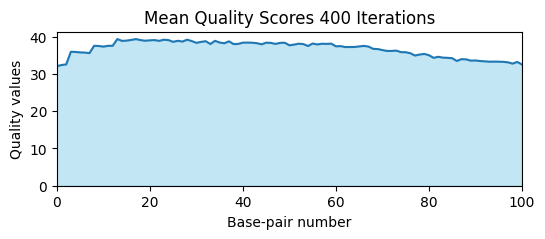

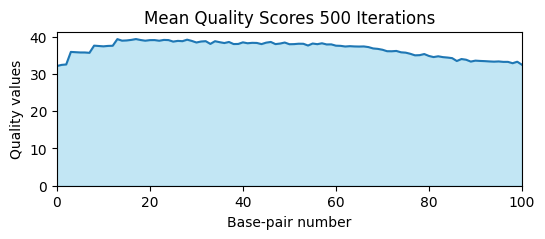

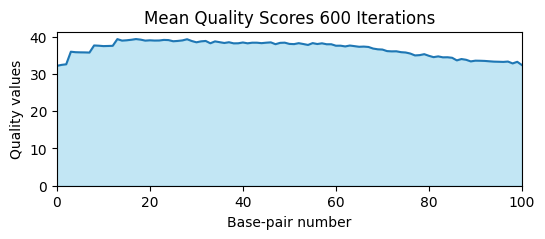

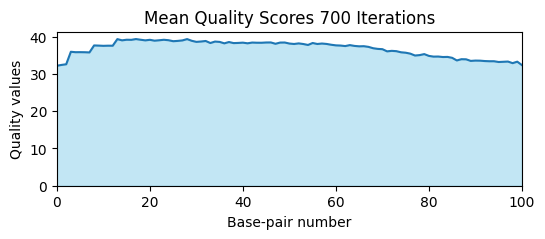

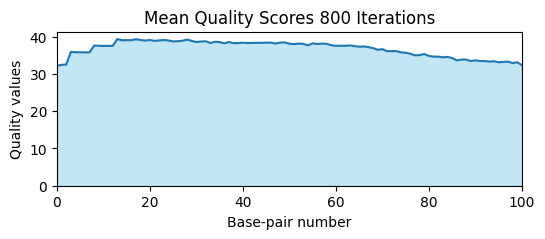

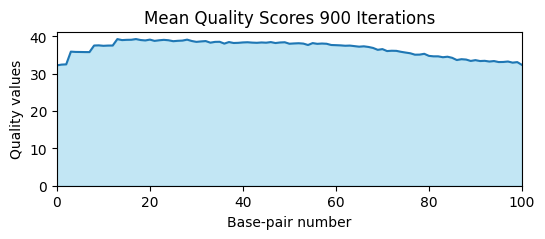

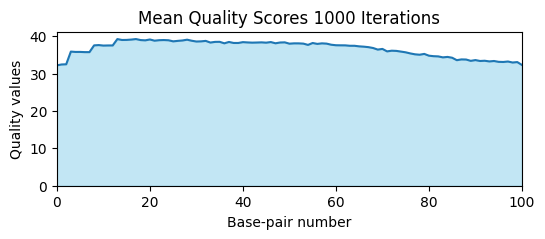

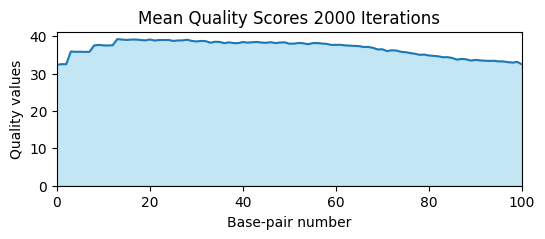

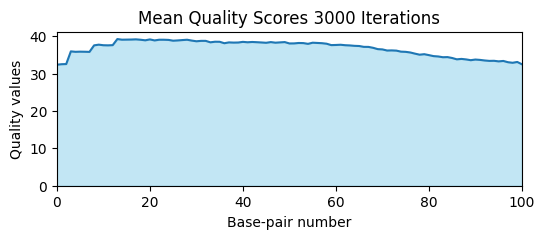

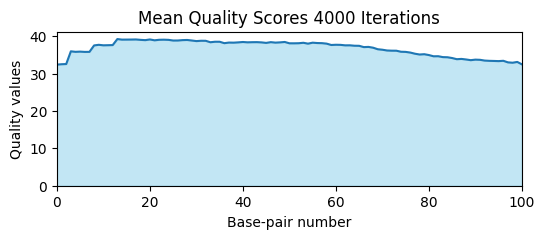

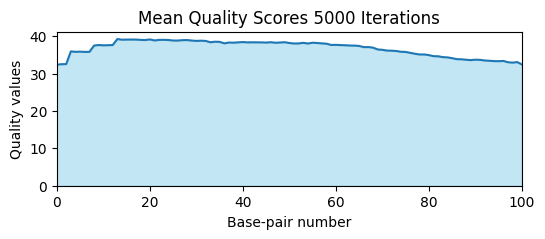

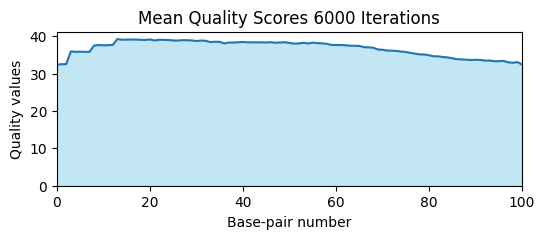

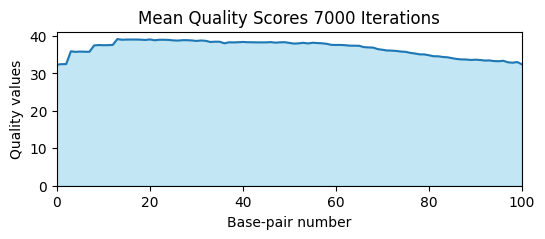

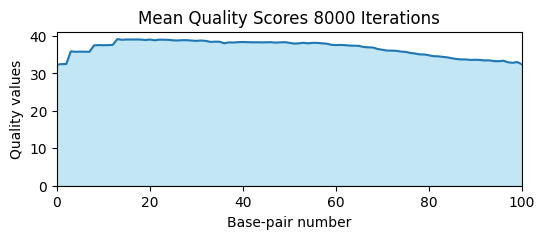

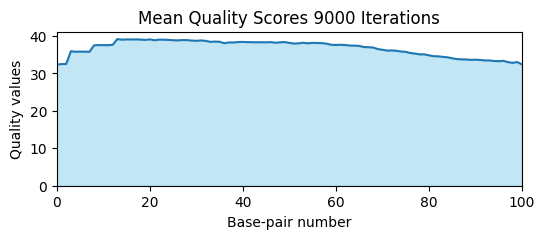

In [179]:
import pysam
from numpy.random import default_rng

from hts_synth.models.qual_model import NaiveQualLearner, NaiveQualSim

fqpath = "../TESTX_H7YRLADXX_S1_L001_R1_001.fastq"

np_rng = default_rng(24601)
with pysam.FastxFile(fqpath) as tfq:
    learned_distribs = NaiveQualLearner.model_from_fastq(tfq)
    qual_gen = NaiveQualSim(learned_distribs, np_rng)
    example_score_iter = qual_gen.yield_n(10)

    example_score = next(qual_gen.yield_n(1))
    plot(
        np.arange(len(example_score)),
        example_score,
        title="Example Quality Scores",
        xlabel="Base-pair number",
        ylabel="Quality values",
        save_path="example_quality_scores.png",
    )

    save_points = (
        list(range(1, 10))
        + list(range(10, 100, 10))
        + list(range(100, 1000, 100))
        + list(range(1000, 10000, 1000))
    )
    quality_generator = qual_gen.yield_n(10001)
    scores = []

    for score in quality_generator:
        scores.append(score)

        if len(scores) not in save_points:
            continue

        mean_scores = np.mean(scores, axis=0)
        plot(
            np.arange(len(score)),
            mean_scores,
            title=f"Mean Quality Scores {len(scores)} Iterations",
            xlabel="Base-pair number",
            ylabel="Quality values",
            # save_path=f"mean_quality_scores_{len(scores)}.png",
        )